# K-means Clustering

In [1]:
"""Set up grid
"""
%load_ext autoreload
%autoreload 2

import numpy as np

# Define a grid of points in 2D space
n_x = n_y = 40
x = np.linspace(0, 10, n_x)
y = np.linspace(0, 10, n_y)
X, Y = np.meshgrid(x, y)
# Grid to define Gaussians
grid = np.dstack((X, Y))
assert grid.shape == (n_x, n_y, 2), 'Nx, Ny, Ndim'

# Reshape for format expected by kmeans algorithm
# i.e. grid[1, 0, :] == grid_reshaped[40, :]
grid_reshaped = grid.reshape(-1, 2)
assert grid_reshaped.shape == (n_x * n_y, 2), 'Npoints, Ndim'

In [2]:
"""Set up Gaussians on grid
"""
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Place a Gaussian distribution in each quadrant of the cubic grid
mu1 = [2.5, 2.5]
mu2 = [7.5, 2.5]
mu3 = [2.5, 7.5]
mu4 = [7.5, 7.5]
cov = [[0.75, 0], [0, 0.75]]  # Covariance matrix: Diagonals are variances == std^2 i.e. (Gaussian width)^2

z1 = multivariate_normal.pdf(grid, mean=mu1, cov=cov)
z2 = multivariate_normal.pdf(grid, mean=mu2, cov=cov)
z3 = multivariate_normal.pdf(grid, mean=mu3, cov=cov)
z4 = multivariate_normal.pdf(grid, mean=mu4, cov=cov)
z_total = z1 + z2 + z3 + z4

visualise_gaussians_in_3d = False

if visualise_gaussians_in_3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, z1, cmap='viridis')
    plt.show()

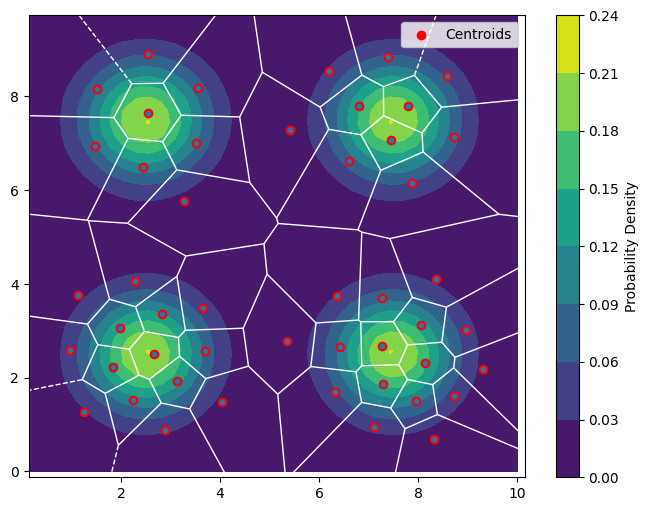

In [3]:
""" Get some optimal centroids and plot overlaid on Gaussians
"""
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from isdf_prototypes.interpolation_points import weighted_kmeans

# Number of interpolating points == N centroids == N clusters
n_inter = 48

# random_indices = np.sort(np.random.choice(grid_reshaped.shape[0], size=n_inter))
random_indices = [10, 19, 31, 39, 93, 119, 148, 242, 255, 262, 267, 359, 364, 377,
411,  436,  440,  457,  468,  477,  525,  562,  565,  592,  614,  624,  628,  662,
754,  832,  855,  877,  894,  971,  985, 1028, 1086, 1208, 1209, 1261, 1269, 1344,
425, 1461, 1493, 1498, 1582, 1590]

initial_centroids = grid_reshaped[random_indices, :]
weights = z_total.reshape(-1)

assert len(random_indices) == n_inter
assert weights.shape == (1600,)

centroids, iter = weighted_kmeans(grid_reshaped, weights, initial_centroids,
                                      n_iter=100, centroid_tol=1.0e-9,
                                      safe_mode=True, verbose=False)

# Gaussians on grid
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, z_total, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Probability Density')
# Centroids
ax.scatter(centroids[:, 0], centroids[:, 1], color='red', label='Centroids')
# Voronoi diagram
vor = Voronoi(centroids)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="white")
ax.legend()
plt.show()


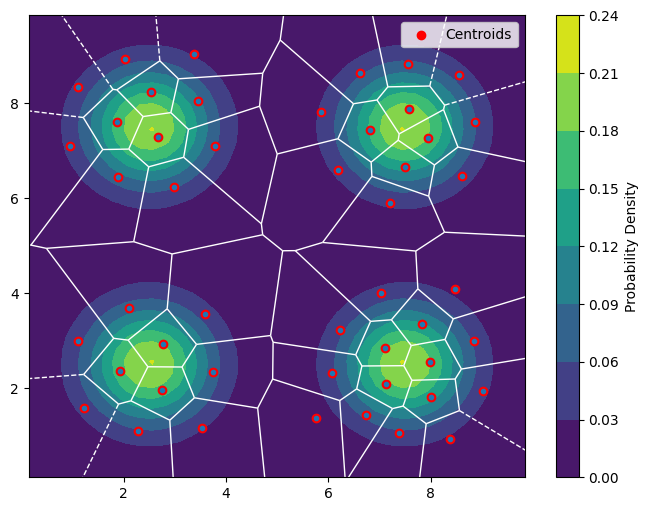

In [7]:
""" Repeat of the above, but using kmeans++
i.e. seed the initial positions of the centroids.
Note that this seeding is not easily testable, as it depends on random sampling

In general (i.e. from evaluating several runs), the result does look better than choosing random seeds
i.e. there's a more even spread of points between the 4 Gaussians
"""
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from isdf_prototypes.interpolation_points import weighted_kmeans, kmeans_seeding

weights = z_total.reshape(-1)
assert weights.shape[0] == grid_reshaped.shape[0]

# Number of interpolating points == N centroids == N clusters
n_inter = 48
initial_centroids = kmeans_seeding(grid_reshaped, n_inter)
centroids, iter = weighted_kmeans(grid_reshaped, weights, initial_centroids,
                                      n_iter=100, centroid_tol=1.0e-9,
                                      safe_mode=True, verbose=False)

# Gaussians on grid
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, z_total, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Probability Density')
# Centroids
ax.scatter(centroids[:, 0], centroids[:, 1], color='red', label='Centroids')
# Voronoi diagram
vor = Voronoi(centroids)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="white")
ax.legend()
plt.show()






## TODOs

* Benchmark against sklearn: See how that performs for the same number of clusters, and same seeds
* I've implemented k-means++ but it would be worth looking at 
*   a) greedy k-means. 
*   b) SKLearn's implementation, [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), specifically from line [178](https://github.com/scikit-learn/scikit-learn/blob/f07e0138b/sklearn/cluster/_kmeans.py)
* [Optimise number of centroids](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py).

	•	Implement MPI-parallelisation over grid points.
	•	Compare to SKLearn for some options
	⁃	See if optimal grid point analysis then improves my implementation
	⁃	If so, Implement silhouette analysis  for ~ 10 choices of N_interp, distributed around 20 * N (where N is states).
	⁃	So N, 2N 4N 9N 10N, 15N.... 